# *Library*
Import *library* yang dibutuhkan.

In [1]:
!pip3 install num2words # Install library untuk mengubah angka menjadi kata.
!pip install Sastrawi # Karena wordnet tidak bisa digunakan maka di sini pakai Sastrawi.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.8 MB/s eta 0:00:00


In [2]:
# Library untuk membaca file .csv.
import pandas as pd
# Library untuk visualisasi.
import matplotlib.pyplot as plt
import seaborn as sns
# Library untuk memproses teks.
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import one_hot
from num2words import num2words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# Library untuk membangun model.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np
# Library untuk memisahkan dataset.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Library untuk evaluasi model.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
nltk.download('punkt') # Untuk tokenizer kata.
nltk.download('stopwords')# Untuk menghapus stopwords.
# nltk.download('wordnet') # Ada masalah ketika menggunakan wordnet.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Membaca Dataset
Melakukan visualisasi dataset yang dimiliki.

In [4]:
df = pd.read_csv("/kaggle/input/data-mh-id/data_mh.csv", delimiter=",") # Sesuaikan `delimiter` berdasarkan bahasa yang digunakan dalma .csv.
df.head()

,text,is_depression,text_id
0,we understand that most people who reply immed...,1,Kami memahami bahwa kebanyakan orang yang sege...
1,welcome to r depression s check in post a plac...,1,Selamat datang di post Depresi S Posting di te...
2,anyone else instead of sleeping more when depr...,1,orang lain daripada lebih banyak tidur ketika ...
3,i ve kind of stuffed around a lot in my life d...,1,Saya telah banyak mengisi banyak dalam hidup s...
4,sleep is my greatest and most comforting escap...,1,Tidur adalah pelarian terbesar dan paling meng...


Visualisasi label, usahakan label yang dimiliki seimbang.

<AxesSubplot:>

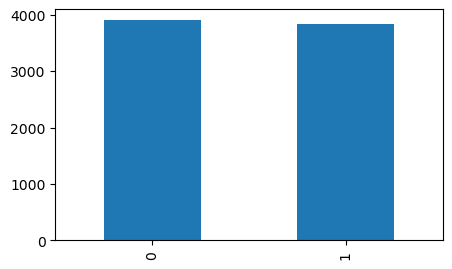

In [5]:
df["is_depression"].value_counts().plot(kind="bar",figsize=(5,3))

In [6]:
# Cek apakah terdapat null value atau tidak.
print(df.isnull().sum())

text             0
is_depression    0
text_id          0
dtype: int64


In [7]:
# Cek tipe data kolom.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           7731 non-null   object
 1   is_depression  7731 non-null   int64 
 2   text_id        7731 non-null   object
dtypes: int64(1), object(2)
memory usage: 181.3+ KB
None


# Memproses Data Teks
Proses data teks seperti menghapus `stop_words`, menjadikannya kata dasar, mengganti angka ke dalam teks, dll.

In [8]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

### def translate_test lebih baik diskip translate via spreadsheet aja
# def translate_text(text):
#     url = "https://translate.googleapis.com/translate_a/single?client=gtx&sl=en&tl=id&dt=t&q={}".format(text)
#     response = requests.get(url)
#     result = response.json()[0][0][0]
#     return result

def preprocess_text(text):
#     text = translate_text(text) # Kemudian di sini kita coba translate
    text = word_tokenize(text.lower()) # Tokenize text_id ke dalam token/kata
    text = [t for t in text if t not in stop_words] # Hapus stop_words
    text = [stemmer.stem(t) for t in text] # Menjadikan kata dasar
    text = [t if not t.isdigit() else num2words(int(t)) for t in text] # Mengganti angka ke teks
#     text = emoji.demojize(text) # ubah emoji ke dalam bentuk teks
#     text = re.sub(r':[a-z_]+:', lambda m: ' '.join(m.group(0).replace(':', '').split('_')), text) # Regex misal emoji: 🎉 bakal diubah jadi "party popper".
    text = ' '.join(text) # Gabungkan ke dalam teks kembali
    return text

In [9]:
df = df[pd.notnull(df['text_id'])] # hapus semua baris dengan nilai NaN di kolom `text`
df = df[df['text_id'].apply(lambda x: isinstance(x, str))] # hapus semua baris di mana `text` bukan string
df['nlp_text'] = df['text_id'].apply(lambda x: preprocess_text(x))

In [10]:
df.head()

,text,is_depression,text_id,nlp_text
0,we understand that most people who reply immed...,1,Kami memahami bahwa kebanyakan orang yang sege...,paham banyak orang balas op undang bicara prib...
1,welcome to r depression s check in post a plac...,1,Selamat datang di post Depresi S Posting di te...,selamat post depresi s posting ambil bagi mili...
2,anyone else instead of sleeping more when depr...,1,orang lain daripada lebih banyak tidur ketika ...,orang tidur depresi begadang malam hindar cepa...
3,i ve kind of stuffed around a lot in my life d...,1,Saya telah banyak mengisi banyak dalam hidup s...,isi hidup tunda orang hindar orang dewasa tang...
4,sleep is my greatest and most comforting escap...,1,Tidur adalah pelarian terbesar dan paling meng...,tidur lari besar hibur kali bangun emosi rasa...


# Hitung Ukuran *Vocabulary*
Memasukan kata unik ke dalam *set* `words`, kemudian untuk menghitung ukuran *vocabulary*.

In [11]:
words = set(word for sentence in df["nlp_text"] for word in sentence.split())
vocab_size = len(words)
print(vocab_size)

14233


# *One Hot Encoding* untuk Setiap Kalimat
*One-hot encode* teks ke dalam daftar indeks kata berukuran n.

In [12]:
one_hot_representation = [one_hot(words,vocab_size) for words in df["nlp_text"]] # Input teksnya `words` di setiap `df["nlp_text"]` dengan ukuran `vocab_size`
# one_hot_representation

Cari panjang maksimum untuk dimasukan ke dalam word embeddings.

In [13]:
max_len = 0
for elem in one_hot_representation:
    if len(elem) > max_len:
        max_len = len(elem)
max_len

1300

# Mengonversi *One-hot Encodings* ke *Word Embeddings*
Meskipun *one-hot encodings* adalah teknik yang berguna untuk merepresentasikan kata-kata sebagai vektor numerik di NLP, teknik ini memiliki beberapa keterbatasan. Salah satunya adalah vektor *one-hot* berdimensi tinggi dan *sparse*, yang berarti bahwa sebagian besar elemen vektor adalah 0, yang dapat mempersulit algoritma pembelajaran mesin untuk mengekstraksi pola yang bermakna dari data.
Untuk mengatasi keterbatasan ini, kita dapat mengonversi vektor *one-hot* menjadi *word embeddings*, yaitu vektor yang sifatnya *dense* berdimensi rendah yang merepresentasikan kata dalam ruang vektor kontinu.

Ketika panjang sequences kurang dari max_length maka pad_sequences akan menambahkan padding supaya jumlahnya sama dengan max_length. padding = 'post' dibuat untuk menambahkan padding di akhir, jika padding = 'pre' maka padding akan ditambahkan di awal sequences.

Kemudian apabila panjang sequences lebih dari max_length maka akan ditruncate. padding = 'post' dibuat untuk truncate di akhir, jika padding = 'pre' maka dibuat untuk truncate di awal.

In [14]:
# embedded_docs = pad_sequences(one_hot_representation, padding='pre', maxlen = max_len)
embedded_docs = pad_sequences(one_hot_representation, padding = 'post',truncating = 'post', maxlen = max_len)

In [15]:
### Model 1
# embedding_vector_features = max_len * 2
# model = Sequential()
# model.add(Embedding(14233, embedding_vector_features, input_length=max_len))
# model.add((LSTM(100)))
# model.add(Dense(1,activation = 'sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# print(model.summary())

In [16]:
### Model 2
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=14233, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1300, 100)         1423300   
                                                                 
 bidirectional (Bidirectiona  (None, 1300, 256)        234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,822,277
Trainable params: 1,822,277
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
y = df["is_depression"]

Jumlah sample `y` dengan `embedded_docs` harus sama.

In [18]:
print(f"Shape of y is: {y.shape}")
print(f"Shape of embedded document is: {embedded_docs.shape}")

Shape of y is: (7731,)
Shape of embedded document is: (7731, 1300)


# *Split* Dataset

Di sini kita split `test_size` sebesar 0.1 dikarenakan jumlah datasetnya berukuran besar. Kemudian menggunakan `stratifikasi` dalam fungsi `train_test_split()` memastikan bahwa `training set` dan `test set` memiliki distribusi sampel yang proporsional dari setiap label kelas dalam variabel target, yang dapat membantu jika set data tidak seimbang.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, y, test_size = 0.1, random_state = 42, stratify = y)

In [20]:
# Split data ke dalam training set dan test set (90% training data, 10% test data)
X_train_val, X_test, y_train_val, y_test = train_test_split(embedded_docs, y, test_size=0.1, random_state=42, stratify=y)

# Split data training set yang tersisa ke dalam training set dab validation set (80% training data, 20% validation data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

Setelah membagi data, Anda dapat menggunakan `X_train`, `y_train` untuk melatih model, `X_val`, `y_val` untuk penyetelan hyperparameter, dan `X_test`, `y_test` untuk mengevaluasi kinerja akhir dari model yang dilatih.

In [21]:
print(f"Shape of X train is: {X_train.shape}")
print(f"Shape of y train is: {y_train.shape}")
print(f"Shape of X test is: {X_val.shape}")
print(f"Shape of y test is: {y_val.shape}")
print(f"Shape of X test is: {X_test.shape}")
print(f"Shape of y test is: {y_test.shape}")

Shape of X train is: (5565, 1300)
Shape of y train is: (5565,)
Shape of X test is: (1392, 1300)
Shape of y test is: (1392,)
Shape of X test is: (774, 1300)
Shape of y test is: (774,)


In [22]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=3,batch_size=16) # Kayanya epoch cukup di 3 aja

#### Kalau ga cukup coba pakai chunking (tapi usahain batch_size jangan besar2 nanti abis memori)
# chunk_size = 1000  # set the size of each chunk
# # shuffle the data
# X_train, y_train = shuffle(X_train, y_train)
# # loop through the data in chunks
# for i in range(0, len(X_train), chunk_size):
#     X_chunk = X_train[i:i+chunk_size]
#     y_chunk = y_train[i:i+chunk_size]  
#     # train the model on the current chunk
#     model.fit(X_chunk, y_chunk, epochs=1, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
348/348 [==============================] - 7315s 21s/step - loss: 0.2241 - accuracy: 0.9173 - val_loss: 0.1437 - val_accuracy: 0.9511
Epoch 2/3
348/348 [==============================] - 7301s 21s/step - loss: 0.0911 - accuracy: 0.9700 - val_loss: 0.1535 - val_accuracy: 0.9519
Epoch 3/3
348/348 [==============================] - 7206s 21s/step - loss: 0.0505 - accuracy: 0.9826 - val_loss: 0.1627 - val_accuracy: 0.9490


# Prediksi Model dengan `X_val`

In [23]:
y_pred = model.predict(X_val)

44/44 [==============================] - 51s 1s/step


Probabilitas lebih besar dari atau sama dengan 0.5 akan diberikan ke kelas positif.

In [24]:
y_pred = (y_pred >= 0.5).astype("int")

In [25]:
print(classification_report(y_val,y_pred))
print(confusion_matrix(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       702
           1       0.96      0.94      0.95       690

    accuracy                           0.95      1392
   macro avg       0.95      0.95      0.95      1392
weighted avg       0.95      0.95      0.95      1392

[[674  28]
 [ 43 647]]


In [26]:
y_val = y_val.reset_index(drop = True).values # Reset index `y_val` supaya dari 0 lagi sebelum dikonversi ke dalam array

In [27]:
for i in range(len(y_val)):
    print("True label: {}, Predicted label: {}".format(y_val[i], y_pred[i]))

True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted lab

In [28]:
h = history.history
print(h.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


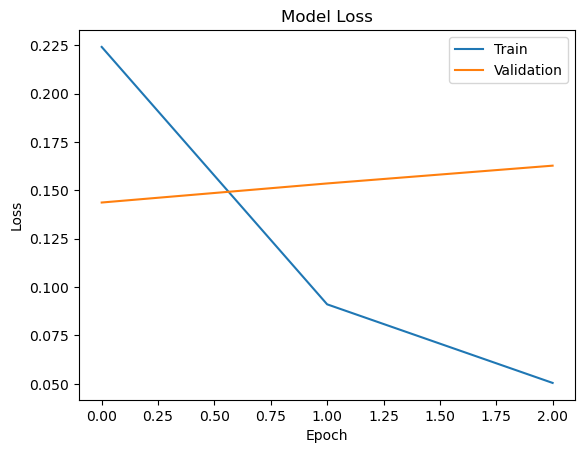

In [29]:
# Plot fungsi loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

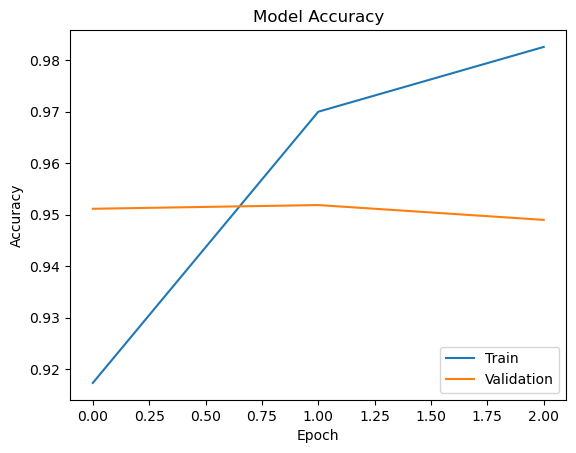

In [30]:
# Plot akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Prediksi Model dengan `X_test`

In [31]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 29s 1s/step


In [32]:
y_pred_test = (y_pred_test >= 0.5).astype("int")

In [33]:
print(classification_report(y_test,y_pred_test))
print(confusion_matrix(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       390
           1       0.94      0.95      0.94       384

    accuracy                           0.94       774
   macro avg       0.94      0.94      0.94       774
weighted avg       0.94      0.94      0.94       774

[[367  23]
 [ 20 364]]


In [34]:
y_test = y_test.reset_index(drop = True).values # Reset index `y_test` supaya dari 0 lagi sebelum dikonversi ke dalam array

In [35]:
for i in range(len(y_test)):
    print("True label: {}, Predicted label: {}".format(y_test[i], y_pred_test[i]))

True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted lab

# Simpan Model

In [36]:
# model.save('model.h5')